In [31]:
import os
from dotenv import load_dotenv
from PyPDF2 import PdfReader   # For reading PDF files
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_core.tools import create_retriever_tool
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model
from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import convert_to_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


In [3]:
load_dotenv()
key = os.getenv("GOOGLE_API_KEY")

In [4]:
pdf_path = "data/nihms-1901028.pdf"

In [7]:
reader = PdfReader(pdf_path)

In [8]:
len(reader.pages)

18

In [9]:
len(reader.pages[0].extract_text())

2966

In [10]:
text = "".join(page.extract_text() for page in reader.pages if page.extract_text())
text

'High and normal protein diets improve body composition and \nglucose control in adults with type 2 diabetes: A randomized \ntrial\nJulianne G. Clina1, R. Drew Sayer1,3, Zhaoxing Pan2, Caroline W. Cohen3, Michael T. \nMcDermott4, Victoria A. Catenacci4, Holly R. Wyatt1,5, James O. Hill1\n1Department of Nutrition Sciences, University of Alabama at Birmingham\n2Department of Pediatrics, University of Colorado Anschutz Medical Campus\n3Department of Family and Community Medicine, University of Alabama at Birmingham\n4Division of Endocrinology, Metabolism and Diabetes, University of Colorado School of Medicine, \nAurora, Colorado\n5Anschutz Health and Wellness Center, University of Colorado Anschutz Medical Campus\nAbstract\nObjective:\xa0 Weight loss of ≥10% improves glucose control and may remit type 2 diabetes \n(T2D). High protein (HP) diets are commonly used for weight loss, but whether protein \nsources, especially red meat, impact weight loss-induced T2D management is unknown. This 

In [12]:

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
chunks = text_splitter.split_text(text)
chunks

['High and normal protein diets improve body composition and \nglucose control in adults with type 2 diabetes: A randomized \ntrial\nJulianne G. Clina1, R. Drew Sayer1,3, Zhaoxing Pan2, Caroline W. Cohen3, Michael T. \nMcDermott4, Victoria A. Catenacci4, Holly R. Wyatt1,5, James O. Hill1',
 'McDermott4, Victoria A. Catenacci4, Holly R. Wyatt1,5, James O. Hill1\n1Department of Nutrition Sciences, University of Alabama at Birmingham\n2Department of Pediatrics, University of Colorado Anschutz Medical Campus\n3Department of Family and Community Medicine, University of Alabama at Birmingham\n4Division of Endocrinology, Metabolism and Diabetes, University of Colorado School of Medicine, \nAurora, Colorado',
 '3Department of Family and Community Medicine, University of Alabama at Birmingham\n4Division of Endocrinology, Metabolism and Diabetes, University of Colorado School of Medicine, \nAurora, Colorado\n5Anschutz Health and Wellness Center, University of Colorado Anschutz Medical Campus\nAb

In [13]:
vectorstore = InMemoryVectorStore.from_texts(
    texts=chunks, embedding=GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
)

E0000 00:00:1761137198.678787   10583 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [14]:
retriever = vectorstore.as_retriever()

In [15]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_medical_information",
    "Search and return information about Protein Diets for Daibetes 2 Patients.",
)

In [16]:
retriever_tool.invoke({"query": "types of protein diets"})

'Food lists for the HP and NP groups were similar, with the exception of the HP group \nbeing asked to consume lean beef ≥4 times per week and the portion sizes for the protein \nbeing reduced for the NP group. Approximate carbohydrate and protein compositions were \n32% and 40% of total energy for the HP diet, respectively and 53% and 21% for the NP\n\nAuthor Manuscript Author Manuscript Author Manuscript Author ManuscriptThe purpose of this randomized clinical trial was to compare a high protein diet (HP) versus \na normal protein diet (NP) for weight loss, body composition changes, and indicators of type \n2 diabetes status during a 52-week behavioral weight loss intervention. Both intervention \ndiets were energy-restricted, and the HP diet included recommendations to include lean\n\n16. Wycherley TP, et al. , Effects of energy-restricted high-protein, low-fat compared with standard-\nprotein, low-fat diets: a meta-analysis of randomized controlled trials. The American journal of \

In [17]:
response_model = init_chat_model("google_genai:gemini-2.5-flash", temperature=0, api_key=key)

E0000 00:00:1761137381.974133   10583 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [18]:
def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])  
    )
    return {"messages": [response]}

In [20]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I help you today?


In [21]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "What Protein diet is best for type 2 diabetes?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_medical_information (d47c5ca1-73ec-4c28-bbc8-7501204de369)
 Call ID: d47c5ca1-73ec-4c28-bbc8-7501204de369
  Args:
    query: Protein diet for type 2 diabetes


In [22]:
class GradeDocuments(BaseModel):
    binary_score: Literal["yes", "no"] = Field(
        description="Relevance score: 'yes' if relevant, 'no' otherwise"
    )

In [23]:
def grade_documents(state: MessagesState):
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    grader_model = init_chat_model("google_genai:gemini-2.5-flash", temperature=0, api_key=key)
    GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(  
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

Irrelevant documents

In [24]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What Protein diet is best for type 2 diabetes?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_medical_information",
                        "args": {"query": "Search and return information about Protein Diets for Daibetes 2 Patients."}
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

E0000 00:00:1761137469.420071   10583 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


'rewrite_question'

Relevant Documents

In [25]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What Protein diet is best for type 2 diabetes?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_medical_information",
                        "args": {"query": "Search and return information about Protein Diets for Diabetes 2 Patients."},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "Diabetes 2 Patients can do high, medium or low protein diets.",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

E0000 00:00:1761137474.015640   10583 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


'generate_answer'

  Original Prompt war:
  REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question"
)

In [26]:
def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question and only return the rephrased question:"
)
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

Test the rewriter

In [ ]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What Protein diet is best for type 2 diabetes?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_medical_information",
                        "args": {"query": "Search and return information about Protein Diets for Diabetes 2 Patients."}
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

What are the recommended types and amounts of protein for individuals with type 2 diabetes to support blood sugar management and overall health?


In [29]:

def generate_answer(state: MessagesState):
    """Generate an answer."""
    
    GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
    )

    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}



In [30]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What Protein diet is best for type 2 diabetes?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_medical_information",
                        "args": {"query": "Search and return information about Protein Diets for Diabetes 2 Patients."},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "There are high, medium and low protein diets and none of them is evidently much better than the other.",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

There isn't one protein diet that is evidently much better than the others for type 2 diabetes. High, medium, and low protein diets have all been considered. Therefore, no specific protein diet can be singled out as the best.


7. Assemble the graph
Now we’ll assemble all the nodes and edges into a complete graph:
Start with a generate_query_or_respond and determine if we need to call retriever_tool
Route to next step using tools_condition:
If generate_query_or_respond returned tool_calls, call retriever_tool to retrieve context
Otherwise, respond directly to the user
Grade retrieved document content for relevance to the question (grade_documents) and route to next step:
If not relevant, rewrite the question using rewrite_question and then call generate_query_or_respond again
If relevant, proceed to generate_answer and generate final response using the ToolMessage with the retrieved document context

In [ ]:
workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile

graph = workflow.compile()

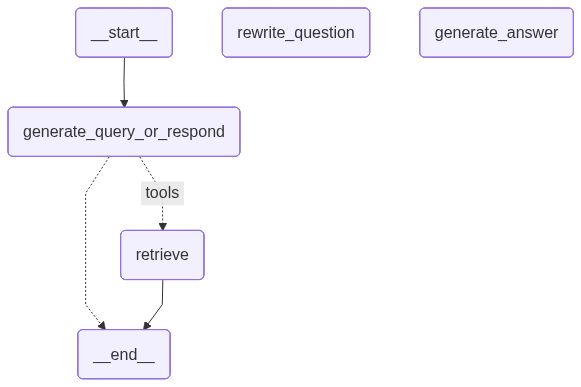

In [34]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What Protein diet is best for type 2 diabetes?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_medical_information (fa23c0ed-de6e-45a1-a8b4-ce87e4801611)
 Call ID: fa23c0ed-de6e-45a1-a8b4-ce87e4801611
  Args:
    query: Protein diet for type 2 diabetes





E0000 00:00:1761141229.384276   10583 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


Update from node retrieve
================================= Tool Message =================================
Name: retrieve_medical_information

High and normal protein diets improve body composition and 
glucose control in adults with type 2 diabetes: A randomized 
trial
Julianne G. Clina1, R. Drew Sayer1,3, Zhaoxing Pan2, Caroline W. Cohen3, Michael T. 
McDermott4, Victoria A. Catenacci4, Holly R. Wyatt1,5, James O. Hill1

Higher protein diets are an attractive target for lifestyle-based interventions for the treatment 
of T2D. High protein diets, especially when combined with exercise, produce greater weight 
loss and prevent losses of fat free mass (FFM) compared to lower protein diets [ 16–18]. In 
premenopausal women with obesity without diabetes, a high protein diet improved insulin 
sensitivity more than a high carbohydrate diet even though achieved weight loss was not

achieving more than 15 kg of weight loss remitted their T2D [ 15]. While it is clear that 
weight loss is assoc